# P5 - Identify Fraud from Enron Email

## 1. Goal of the project

Enron was an energy trading company that was one of the top 10 largest companies in the US in 2001. In 2002, the company was bankrupt and people were put in jail due to corporate fraud and corruption. Enron was involved in the following schemes:

- selling assets to shell companies at the end of each month, and buying them back at the beginning of the               next month to hide accounting losses
- causing electrical grid failures in California

Enron had a second life because of its data set that includes one of the largest corpus of real emails. We will use this data set combined with financial information to indetify persons of interest involved in this fraud by implementing machine learning techniques.

A person of interest is a person who was:
- indicted
- settled without admitting being guilty
- testified in exchange for immunity
        
The aggregated Enron email + financial dataset is stored in a dictionary, where each key in the dictionary is a person’s name, and the value is a dictionary containing all the features of that person. 

In [2]:
#!/usr/bin/python

import sys
import pickle
from time import time
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
sys.path.append("../tools/")

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

%pylab inline

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

Populating the interactive namespace from numpy and matplotlib


## a. Exploring the data set

In [3]:
nb_people=len(data_dict)
print 'Number of people in the dataset: ',nb_people
nb_poi=sum([data_dict[key]['poi']==1 for key in data_dict])
print "Number of persons of interest (POI): ",nb_poi
print "Proportion of POIs in the dataset:",nb_poi/nb_people

Number of people in the dataset:  146
Number of persons of interest (POI):  18
Proportion of POIs in the dataset: 0.123287671233


We observe that out of 146 persons included in the data set, only 18 persons are considered as persons of interest, which reprents 12.3%. The data set is very unbalanced.

How many features are available in the data set?

In [4]:
print 'Number of features available for each person: ', len(data_dict[data_dict.keys()[0]])
print ' '
print 'Name of the features:',data_dict[data_dict.keys()[1]].keys()

Number of features available for each person:  21
 
Name of the features: ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


## b. Outlier investigation

Are there outliers in the data set? We can start by creating a scatter plot with the salary and bonus features.

In [5]:
features_list = ["poi","salary", "bonus"]
data = featureFormat(data_dict, features_list, sort_keys = True)

/Users/yanndupis/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


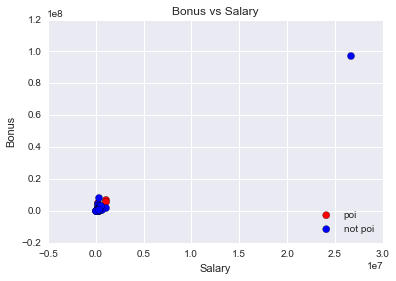

In [6]:
poi=data[:,0]
salary = data[:,1]
bonus = data[:,2]

plt.scatter(salary[poi==1],bonus[poi==1],c='red',s=50,label='poi')
plt.scatter(salary[poi==0],bonus[poi==0],c='blue',s=50,label='not poi')

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.legend(loc='lower right')
plt.title("Bonus vs Salary")
plt.show()

We can observe that there is clearly an outlier with a salary higher than 25,000,000 dollars and a bonus higher than 80,000,000 dollars. But who is this outlier?

In [7]:
outliers=[]
for key in data_dict.keys():
    if (data_dict[key]['bonus']>0.8*1e8) & (data_dict[key]['bonus']!='NaN') & (data_dict[key]['salary']>2.5*1e7):
        outliers.append(key)
print "What's the name of the outlier:",outliers

What's the name of the outlier: ['TOTAL']


It appears that there is a bug in the data set. The outlier is in fact the total of each variable. Let's remove this outlier.

In [8]:
# We use the method pop to remove in the dictionary the item 'TOTAL.
data_dict.pop('TOTAL',0)
data = featureFormat(data_dict, features_list)

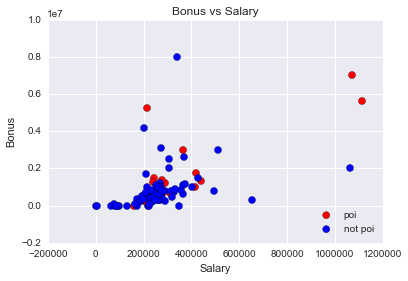

In [9]:
poi=data[:,0]
salary = data[:,1]
bonus = data[:,2]
plt.scatter(salary[poi==1],bonus[poi==1],c='red',s=50,label='poi')
plt.scatter(salary[poi==0],bonus[poi==0],c='blue',s=50,label='not poi')

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Bonus vs Salary")
plt.legend(loc='lower right')
plt.show()

Once we remove the outlier 'TOTAL', we can notice that there are still outliers in the data set. However a big proportion of them are POI. For this reason, it makes sense to keep them in the data set. Maybe POis tend to have higher salaries and bonuses. 

Are there features with many missing values? 

In [10]:
print "Number of persons who have missing values for the salary?",sum([data_dict[key]['salary']=='NaN' for key in data_dict])

Number of persons who have missing values for the salary? 51


Sklearn algorithm needs a numpy array and doesn't handle missing values(NaN). We will use the helper function featureFormat that transforms a dictionary to numpy array and replaces missing values with 0.

# 2. Feature Selection/Engineering

## a. New Feature

Persons of interest may have strong email connections. POIs might send emails to other POIs at a higher rate than the rest of the population. For this reason, let's create two new features: one that represents the fraction of emails that a person sent to POIs, and another feature that represents the fraction of emails that a person received from POIs.

In [11]:
def computeFraction(poi_messages, all_messages):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    
    if poi_messages=='NaN' or all_messages=='NaN':
        fraction = 0.
    else:  
        fraction=float(poi_messages)/float(all_messages)

    return fraction


for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi

In [12]:
fraction_to_poi=[data_dict[key]["fraction_to_poi"] for key in data_dict]
fraction_from_poi=[data_dict[key]["fraction_from_poi"] for key in data_dict]
poi=[data_dict[key]["poi"]==1 for key in data_dict]

Let's create a scatter plot with the fraction of emails the person received from POIs against the fraction of emails the person sent to POIs.

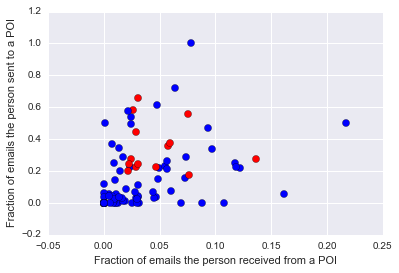

In [14]:
for i in range(len(poi)):
    if poi[i]==1:
        plt.scatter(fraction_from_poi[i],fraction_to_poi[i],c='red',s=50)
    else:
        plt.scatter(fraction_from_poi[i],fraction_to_poi[i],c='blue',s=50)
plt.xlabel('Fraction of emails the person received from a POI') 
plt.ylabel('Fraction of emails the person sent to a POI') 
plt.show()

We can observe that these two features have a discriminating power between POI and non POI. For example, we can observe that there are no POIs with fraction_to_poi<0.2.

## b. Feature Selection

To select the features we will use an automated feature selection function named SelectKBest from the sklearn library. We will tune the parameter K (number of features) at the same time we tune the parameters of the machine learning algorithm during the implementation of cross-validation. If we select the number of features on the entire data set and then we tune the parameters of the machine learning algorithm there is a risk of overfitting.

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

def feature_selection(nb_features,features, labels):
    selector = SelectKBest(f_classif, k=nb_features)
    selector.fit(features, labels)
    return selector

For now, let's create a numpy array including all the features (except email_address) that we will use to train our machine learning algorithm and, at the same time, select the number of features that we want to include in the model.

In [14]:
my_dataset=data_dict

features_list=['poi','salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
'fraction_from_poi',
'fraction_to_poi',
'from_poi_to_this_person',
'from_this_person_to_poi']

We use the helper function to create a numpy array and we split the data set between features and labels.

In [15]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# 3. Validation strategy and evluation metrics

## a. Implementation of cross-validation

To tune the machine learning algorithm we will use the cross-validation method. It's a great method to maximize the accuracy of the metrics we will chose to assess the performance of the algorithm. This method will also correctly tune the algorithm parameters to find the right trade-off between bias and variance in order to make sure that our algorithm is able to generalize (not overfitting).

Usually we use K-cross-validation that consists of spliting the data into K chunks and performs K fits, where each chunk gets a turn as the validation set. 
Here, we will use a different cross-validation method, named StratifiedShuffleSplit, because of the small size of the data set and the unbalanced labels. This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

In [16]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif

def test_classifier(clf, labels, features,nb_features, folds = 1000):
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    precision=0
    recall=0
    f1=0
    f2=0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
            
        #Selection of the best K features   
        selector=feature_selection(nb_features,features_train, labels_train)
        features_train_transformed = selector.transform(features_train)
        features_test_transformed  = selector.transform(features_test)    
            
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train_transformed, labels_train)
        predictions = clf.predict(features_test_transformed)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                break
   
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
    except:
        #print "Got a divide by zero when trying out:", clf
        None
    return precision,recall,f1,f2

## b. Evaluation metrics

To assess the performance of our algorithm we will look at two evaluation metrics:

- **Precision** = true positives/(true positives + false positives)
- **Recall** = true positives/(true positives + false negatives)
      
There’s usually a tradeoff between precision and recall. Sometimes the identifier doesn't have great precision, but it does have good recall. That means that, nearly every time a POI shows up in the test set, we are able to identify him or her. The cost of this is that we sometimes get some false positives, where non-POI get flagged.

Sometimes, instead, the identifier doesn't have a great recall, but it does have good precision. That means that whenever a POI gets flagged in the test set, we know with a lot of confidence that it's very likely to be a real POI and not a false alarm. On the other hand, the price we pay for this is that we sometimes miss real POIs, since we are reclucant to pull the trigger on edge cases. 

For this project we want that precision and recall are both at least 0.3.

We will also compute the **F-score** that combines precision and recall. There are two versions of the F-score. The F1 score put the same weight on precision and recall, however F2 score put more wights on recall.

# 4. Choosing and tuning the algorithm

## a. Gaussian Naive Bayes (GaussianNB)

For the Gaussian Naive Bayes algorithm there are not specific parameters to tune, however we need to select the number of features.

In [17]:
from sklearn.naive_bayes import GaussianNB

nb_features_orig=len(features[1])

#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]
nb_feature_store=[]

#Classifier
clf=GaussianNB()

#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,nb_features_orig+1):
    
    #We use cross-validation and we calculate precision and recall metrics
    precision,recall,f1,f2=test_classifier(clf, labels, features,nb_features, folds = 1000)
    #We record the evaluation metrics for each case               
    precision_result.append(precision)
    recall_result.append(recall)     
    f1_result.append(f1)
    f2_result.append(f2)
    nb_feature_store.append(nb_features)

/Users/yanndupis/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)


Let's plot the precision and recall by number of features selected in the model.

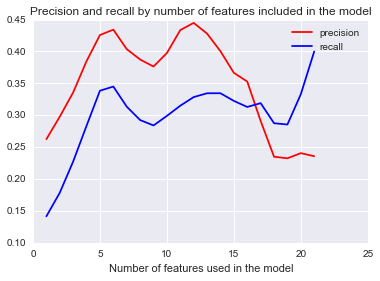

In [18]:
plt.plot(range(1,nb_features_orig+1),precision_result,c='red',label='precision')
plt.plot(range(1,nb_features_orig+1),recall_result,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.title("Precision and recall by number of features included in the model")
plt.legend()
plt.show()

We observe that if we select 6 best features we have the best performance with a precision and recall higher than 0.3. We have interesting performance with 14 features but we'd rather create a simpler model with fewer features.

What are the exact precision and recall when we select the 6 best features?

In [19]:
print "Precsion when the 6 best features are selected:",precision_result[5]
print "Recall when the 6 best features are selected",recall_result[5]

Precsion when the 6 best features are selected: 0.434235368156
Recall when the 6 best features are selected 0.345


In [20]:
selector=feature_selection(6,features, labels)

In [21]:
import pandas as pd
feature_importance=pd.DataFrame([features_list[1:],list(selector.scores_)]).T
feature_importance.columns=['feature_name','score']
feature_importance.sort_values('score',ascending=False)

,feature_name,score
4,exercised_stock_options,25.0975
9,total_stock_value,24.4677
5,bonus,21.06
0,salary,18.5757
18,fraction_to_poi,16.6417
15,deferred_income,11.5955
16,long_term_incentive,10.0725
6,restricted_stock,9.3467
3,total_payments,8.86672
7,shared_receipt_with_poi,8.74649


The 6 best features are:
- exercised_stock_option
- total_stock_value
- bonus 
- salary
- fraction_to_poi
- deferred_income

## b. K-Nearest Neighbors

Let's try the K-Nearest Neighbors algorithm. Before training this algorithm, it's important to rescale the features because the algorithm compute the euclidian distance and it will be more affected my large features.

In [22]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler=MinMaxScaler()
features=min_max_scaler.fit_transform(features)

One parameter which is important to tune for the k-Nearest-neighbors is the number of neighbors. If we set n_neighbors=1, the person is going to be labeled based on the closest neighbor. If we set n_neighbors=10, the person is going to labeled based on the 10 nearest neighbors. When the number of neighbors is small, the bias is low, however the variance is high. That's why it's important to find the right trade-off by using a cross-validation method to tune the parameter.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

nb_features_orig=len(features[1])

#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]

nb_neighbors_store=[]
nb_feature_store=[]

#Number of neighbours tested
nb_neighbors=[1,2,3,5,10,20,30]

#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,nb_features_orig+1):
    #Number of neighbours
    for k in range(len(nb_neighbors)):
        
        #classifier
        clf =KNeighborsClassifier(n_neighbors=nb_neighbors[k])
        #We use cross-validation and we calculate precision and recall metrics
        precision,recall,f1,f2=test_classifier(clf, labels, features,nb_features, folds = 1000)
        
        #We record the evaluation metrics for each case
        precision_result.append(precision)
        recall_result.append(recall)     
        f1_result.append(f1)
        f2_result.append(f2)
        nb_feature_store.append(nb_features)
        nb_neighbors_store.append(nb_neighbors[k])

Let's create a pandas DataFrame with the avaluation metrics (precision, recall, f1,f2) for each case simulated.

In [24]:
import pandas as pd
result=pd.DataFrame([nb_feature_store,nb_neighbors_store,precision_result,recall_result,f1_result,f2_result]).T
result.columns=['nb_feature','nb_neighbors','precision','recall','f1','f2']
result.head()

,nb_feature,nb_neighbors,precision,recall,f1,f2
0,1,1,0.207246,0.1945,0.200671,0.196922
1,1,2,0.251055,0.0595,0.096200,0.070215
2,1,3,0.191111,0.0860,0.118621,0.096629
3,1,5,0.323017,0.0835,0.132698,0.098039
4,1,10,0.000000,0.0000,0.000000,0.000000


First, we want to determine how many features we want to select to have the best precision and recall.

We select the best F2-score for each number of features included in the model. We use the F2 score instead of F1 socre because it puts more weight on recall. This is important because recall tends to be lower, and we want to find precision and recall higher than 0.3.

In [25]:
result_sort_by_f2=result.sort_values('f2',ascending=False)
result_group=result_sort_by_f2.groupby('nb_feature')

In [26]:
top_param_by_nbfeature=result_group.head(1).sort_values('nb_feature')
top_param_by_nbfeature.head()

,nb_feature,nb_neighbors,precision,recall,f1,f2
0,1,1,0.207246,0.1945,0.200671,0.196922
7,2,1,0.182790,0.1795,0.181130,0.180149
14,3,1,0.300465,0.2910,0.295657,0.292845
21,4,1,0.298264,0.2835,0.290695,0.286335
30,5,3,0.283772,0.1670,0.210261,0.181977


Let's plot the precision and recall by number of features selected in the model.

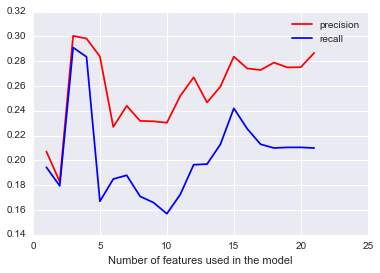

In [27]:
plt.plot(top_param_by_nbfeature.nb_feature,top_param_by_nbfeature.precision,c='red',label='precision')
plt.plot(top_param_by_nbfeature.nb_feature,top_param_by_nbfeature.recall,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.legend()
plt.show()

The 4 best features selected seems to provide the best performance. However the recall is lower than 0.3.

If we select the 4 best variables, what's the number of neighbors that provides the best precision and recall (f2)?

In [28]:
top_param_by_nbfeature[top_param_by_nbfeature.nb_feature==4]

,nb_feature,nb_neighbors,precision,recall,f1,f2
21,4,1,0.298264,0.2835,0.290695,0.286335


The answer is nb_neighbors=1.

## c. Support Vector Machine 

The features are already rescaled. It's important to scale features because the decision boundary is affected by the size of the feature when the algorithm maximizes the margin. 

For the support vector machine algorithm, we need to tune the following parameters:
- **C** : controls tradeoff between smooth decision boundary and classifying training point correctly. When C gets large we expect more training points correct however there is a risk of overfitting.
- **kernel** : transform the input space in a a much larger input space to be linearaly seperable. Here we will use the radial ('rbf') kernel because it takes too much time to train the algorithm with linear kernel.
- **gamma** : Kernel coefficient for ‘rbf’

In [29]:
from sklearn.svm import SVC

nb_features_orig=len(features[1])
#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]

C_param_store=[]
gamma_param_store=[]
nb_feature_store=[]

C_param= [0.1,1.0,1e1,1e2,1e3, 5e3, 1e4, 5e4, 1e5]
gamma_param=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]

for nb_features in range(1,nb_features_orig+1):
    
    best_precision=0
    best_recall=0
    best_f1=0
    
    for i in range(len(C_param)):
        for j in range(len(gamma_param)):
            
            clf=SVC(kernel='rbf',C=C_param[i],gamma=gamma_param[j])

            #We use cross-validation and we calculate precision and recall metrics
            precision,recall,f1,f2=test_classifier(clf, labels, features,nb_features, folds = 1000)
        
            #We record the evaluation metrics for each case
            precision_result.append(precision)
            recall_result.append(recall)     
            f1_result.append(f1)
            f2_result.append(f2)
            C_param_store.append(C_param[i])
            gamma_param_store.append(gamma_param[j])
            nb_feature_store.append(nb_features)

Let's create a pandas DataFrame with the avaluation metrics (precision, recall, f1,f2) for each case simulated.

In [30]:
import pandas as pd
result=pd.DataFrame([nb_feature_store, C_param_store,gamma_param_store,precision_result,recall_result,f1_result,f2_result]).T
result.columns=['nb_feature','C','gamma','precision','recall','f1','f2']
result.head()

,nb_feature,C,gamma,precision,recall,f1,f2
0,1,0.1,0.0001,0,0,0,0
1,1,0.1,0.0005,0,0,0,0
2,1,0.1,0.0010,0,0,0,0
3,1,0.1,0.0050,0,0,0,0
4,1,0.1,0.0100,0,0,0,0


First, we want to determine how many features we want to select to have the best precision and recall.

We select the best F2-score for each number of features included in the model. We use the F2 score instead of F1 socre because it puts more weight on recall which is important because recall tends to be lower and we want to find precision and recall higher than 0.3.

In [31]:
result_sort_by_f2=result.sort_values('f2',ascending=False)
result_group=result_sort_by_f2.groupby('nb_feature')

In [32]:
top_param_by_nbfeature=result_group.head(1).sort_values('nb_feature')
top_param_by_nbfeature.head()

,nb_feature,C,gamma,precision,recall,f1,f2
53,1,100000,0.10,0.504926,0.1025,0.170407,0.121937
107,2,100000,0.10,0.570455,0.1255,0.205738,0.148697
160,3,100000,0.01,0.562222,0.1265,0.206531,0.149704
214,4,100000,0.01,0.536926,0.1345,0.215114,0.158217
269,5,100000,0.10,0.302770,0.1585,0.208074,0.175196


Let's plot the precision and recall by number of features selected in the model.

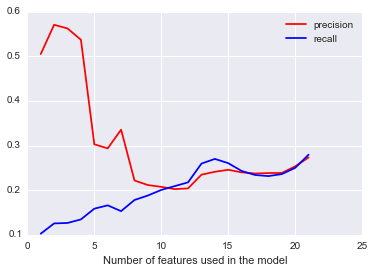

In [33]:
plt.plot(top_param_by_nbfeature.nb_feature,top_param_by_nbfeature.precision,c='red',label='precision')
plt.plot(top_param_by_nbfeature.nb_feature,top_param_by_nbfeature.recall,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.legend()
plt.show()

We can observe that with Support Vector Machine, we can acheive a high precision (more than 0.5) when we select the 2 or 3 best variables. However recall is lower than 0.2. When more than 10 features are selected, precision and recall tend to converge but they are still lower than 0.3. 

It should be noted that the best f2 we can reach by selecting the two best features is 0.148. To achieve this f2 we need to set the C parameter equal to 100000 and gamma=0.1.

In [34]:
top_param_by_nbfeature[top_param_by_nbfeature.nb_feature==2]

,nb_feature,C,gamma,precision,recall,f1,f2
107,2,100000,0.1,0.570455,0.1255,0.205738,0.148697


# 5. Conclusion

The goal of this project was to achieve a precision and recall higher than 0.3. That's why we will use Gaussian Naive Bayes algorithm to identify persons of interest. We will include in the model the 6 following features:

- exercised_stock_option
- total_stock_value
- bonus 
- salary
- fraction_to_poi
- deferred_income


# 6. Udacity Tester

What's the result return by the tester provided by Udacity when we apply the algorithm selected above?

In [35]:
data_dict = pickle.load(open("final_project_dataset.pkl", "r"))

#We remove the outlier 'TOTAL'.
data_dict.pop('TOTAL',0)

#We create the feature 'fraction_from_poi' and 'fraction_to_poi'.
def computeFraction(poi_messages, all_messages):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    
    if poi_messages=='NaN' or all_messages=='NaN':
        fraction = 0.
    else:  
        fraction=float(poi_messages)/float(all_messages)

    return fraction


for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi

#We select the features
features_list = ["poi","exercised_stock_options", "total_stock_value","bonus","salary","fraction_to_poi","deferred_income"]
my_dataset=data_dict
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#We select the classifier, Gaussian Naive Bayes.
clf=GaussianNB()

#We train the classifier.
clf.fit(data,labels)

GaussianNB()

In [36]:
dump_classifier_and_data(clf, my_dataset, features_list)

In [37]:
sys.path.append("../final_project/")
from tester import load_classifier_and_data,test_classifier

clf, dataset, feature_list = load_classifier_and_data()
test_classifier(clf, dataset, feature_list)

GaussianNB()
	Accuracy: 0.86050	Precision: 0.51572	Recall: 0.38550	F1: 0.44120	F2: 0.40600
	Total predictions: 14000	True positives:  771	False positives:  724	False negatives: 1229	True negatives: 11276



When we run the Udacity tester we get precision of 0.52 and a recall of 0.39, both of which are above 0.3.

# Ressources

- Udacity Machine Learning class
- scikit learn documentation